Data and trained model loaded successfully.

--- Task 3: Forecasting Future Market Trends ---
LSTM model retrained on full dataset for forecasting.
Forecast generated and saved.


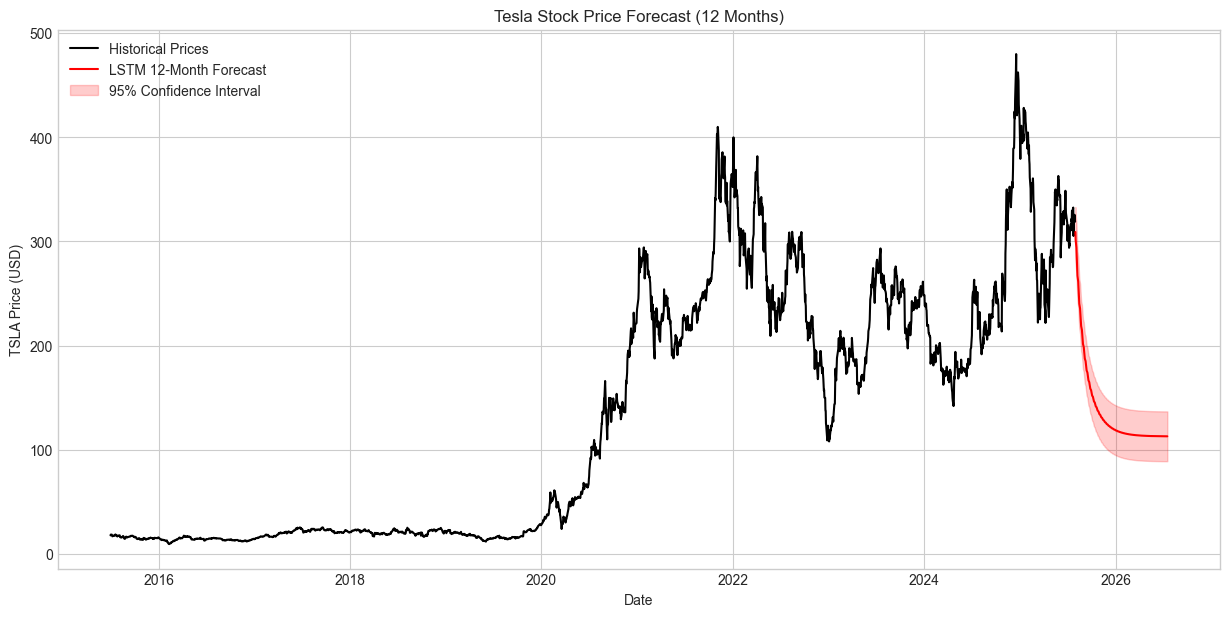

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Add the project's root directory to the Python path
# This allows the notebook to find the 'scripts' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from scripts.model_training import create_sequences, forecast_lstm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

plt.style.use('seaborn-v0_8-whitegrid')

# Load data and the trained LSTM model
try:
    clean_prices = pd.read_csv('../data/processed/clean_prices.csv', index_col=0, parse_dates=True)
    tsla_data = clean_prices['TSLA']
    model_lstm = load_model('../data/processed/lstm_model.keras')
    print("Data and trained model loaded successfully.")
except FileNotFoundError:
    print("Error: Please run task1_eda.ipynb and task2_modeling.ipynb first.")
    raise

# --- Task 3: Forecast Future Market Trends ---
print("\n--- Task 3: Forecasting Future Market Trends ---")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_data.values.reshape(-1, 1))
seq_length = 60

# Retrain model on full data for best forecast
X, y = create_sequences(scaled_data, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)
model_lstm.fit(X, y, batch_size=32, epochs=50, verbose=0)
print("LSTM model retrained on full dataset for forecasting.")

# Generate a 12-month forecast
forecast_days = 252 
last_sequence = scaled_data[-seq_length:]
forecast_prices = forecast_lstm(model_lstm, last_sequence, scaler, forecast_days)
forecast_dates = pd.date_range(start=tsla_data.index[-1], periods=forecast_days + 1, freq='B')[1:]

# Calculate heuristic confidence intervals
train_size = int(len(tsla_data) * 0.8)
test_data = tsla_data[train_size:]
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test_sequences, _ = create_sequences(scaled_test_data, seq_length)
X_test_sequences = X_test_sequences.reshape(X_test_sequences.shape[0], X_test_sequences.shape[1], 1)
test_predictions_scaled = model_lstm.predict(X_test_sequences, verbose=0)
test_predictions = scaler.inverse_transform(test_predictions_scaled)
residuals = test_data[seq_length:].values.reshape(-1, 1) - test_predictions
residual_std = np.std(residuals)
confidence_interval = 1.96 * residual_std

# Save the forecast for Task 4
forecast_df = pd.DataFrame(forecast_prices, index=forecast_dates, columns=['TSLA_Forecast'])
forecast_df.to_csv('../data/processed/tsla_forecast.csv')
print("Forecast generated and saved.")

# Visualize the Forecast
plt.figure(figsize=(15, 7))
plt.plot(tsla_data.index, tsla_data, label='Historical Prices', color='black')
plt.plot(forecast_dates, forecast_prices, label='LSTM 12-Month Forecast', color='red')
plt.fill_between(
    forecast_dates,
    forecast_prices.flatten() - confidence_interval,
    forecast_prices.flatten() + confidence_interval,
    color='red', alpha=0.2, label='95% Confidence Interval'
)
plt.title('Tesla Stock Price Forecast (12 Months)')
plt.xlabel('Date')
plt.ylabel('TSLA Price (USD)')
plt.legend()
plt.show()